In [ ]:
!pip install tpot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 9.1 MB/s eta 0:00:00
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=788c5673677756c1270fae9212f4c4da3b94b35e1a7528c089ad4d36c9767ee8
  Stored in directory: /root/.cache/pip/wheels/da/77/2d/adbc56bc4db95ad80c6d4e71cd69e2d9d122174904342e3f7f
Successfully built stopit


In [ ]:
import pandas as pd

df = pd.read_csv("/content/data.csv")
print(df.columns)

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	5     
1  	4     
2  	2     
3  	1     
4  	2     
5  	3     
6  	1     
7  	1     
8  	1     
9  	3     
10 	1     
 Model: Random Forest
 Accuracy: 0.9720
 Precision: 1.0000
 Recall (Sensitivity): 0.9245
 F1 Score: 0.9608
 AUC Score: 0.9623
 Confusion Matrix:
 [[90  0]
 [ 4 49]]
 Model: Gradient Boosting Trees
 Accuracy: 0.9441
 Precision: 0.9787
 Recall (Sensitivity): 0.8679
 F1 Score: 0.9200
 AUC Score: 0.9284
 Confusion Matrix:
 [[89  1]
 [ 7 46]]
 Model: Multi-Layer Perceptron
 Accuracy: 0.9580
 Precision: 0.9608
 Recall (Sensitivity): 0.9245
 F1 Score: 0.9423
 AUC Score: 0.9512
 Confusion Matrix:
 [[88  2]
 [ 4 49]]


<ipython-input-14-c6e94344bc3b>:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


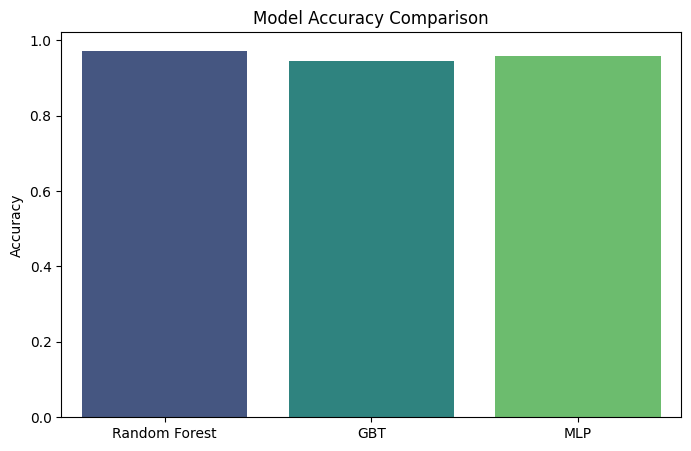

In [ ]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn deap tpot

# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from deap import base, creator, tools, algorithms

# ------------------------- DATA COLLECTION & PREPROCESSING -------------------------

#Load Dataset
df = pd.read_csv("data.csv")

# Drop unnecessary columns
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True, errors='ignore')

# Handle missing values using mode imputation
imputer = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Convert categorical columns to numeric encoding
categorical_cols = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
                    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
                    'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se',
                    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
                    'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

for col in categorical_cols:
    df[col] = df[col].astype(float)

# Define feature and target variables
X = df.drop(columns=['diagnosis'])  # All features
y = df['diagnosis']  # Target variable (1 = malignant, 0 = benign)
# Convert target variable 'diagnosis' to numerical (M = 1, B = 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})


# Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Apply SMOTE for class balancing
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# ------------------------- MODELING & GENETIC ALGORITHM (GA) -------------------------

# Genetic Algorithm Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 10, 200)  # Random estimators (10-200)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness Function to optimize model accuracy
def eval_model(individual):
    n_estimators = int(individual[0])
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=5, random_state=42)
    skf = StratifiedKFold(n_splits=3)
    scores = []

    for train_idx, val_idx in skf.split(X_train_res, y_train_res):
        X_train_fold, X_val_fold = X_train_res[train_idx], X_train_res[val_idx]
        y_train_fold, y_val_fold = y_train_res.iloc[train_idx], y_train_res.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        scores.append(accuracy_score(y_val_fold, y_pred_fold))

    return (np.mean(scores),)

toolbox.register("evaluate", eval_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run Genetic Algorithm
pop = toolbox.population(n=5)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

# Select best hyperparameter
best_params = tools.selBest(pop, k=1)[0]
best_n_estimators = int(best_params[0])

# ------------------------- TRAINING MODELS -------------------------

# Train Random Forest with optimized hyperparameters
rf_model = RandomForestClassifier(n_estimators=best_n_estimators, min_samples_split=5, random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Train Gradient Boosting Trees
gbt_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.1, max_depth=5, random_state=42)
gbt_model.fit(X_train_res, y_train_res)

# Train Multi-Layer Perceptron
mlp_model = MLPClassifier(hidden_layer_sizes=(10,), activation='tanh', solver='adam', alpha=0.01, max_iter=1000, random_state=42)
mlp_model.fit(X_train_res, y_train_res)

# ------------------------- MODEL EVALUATION -------------------------

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    y_test = np.where(y_test == 'M', 1, 0)
    y_pred = np.where(y_pred == 'M', 1, 0)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f" Model: {model_name}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall (Sensitivity): {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")
    print(f" AUC Score: {auc:.4f}")
    print(f" Confusion Matrix:\n {cm}")

    return accuracy, precision, recall, f1, auc


# Evaluate Models
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(gbt_model, X_test, y_test, "Gradient Boosting Trees")
evaluate_model(mlp_model, X_test, y_test, "Multi-Layer Perceptron")

# ------------------------- VISUALIZATION -------------------------

# Compare Performance
models = ["Random Forest", "GBT", "MLP"]
accuracies = [rf_model.score(X_test, y_test), gbt_model.score(X_test, y_test), mlp_model.score(X_test, y_test)]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


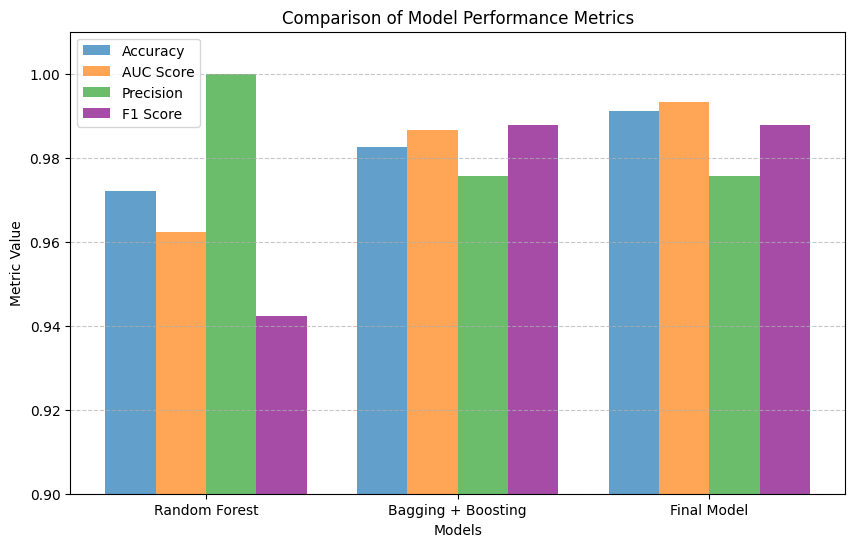

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ["Random Forest", "Bagging + Boosting", "Final Model"]
accuracy = [0.9720, 0.9825, 0.9912]
auc_score = [0.9623, 0.9865, 0.9932]
precision = [1.0000, 0.9756, 0.9756]
f1_score = [0.9423, 0.9877, 0.9877]

x = np.arange(len(models))
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric
ax.bar(x - 1.5 * width, accuracy, width, label="Accuracy", alpha=0.7)
ax.bar(x - 0.5 * width, auc_score, width, label="AUC Score", alpha=0.7)
ax.bar(x + 0.5 * width, precision, width, label="Precision", alpha=0.7)
ax.bar(x + 1.5 * width, [f1_score[0], f1_score[1], f1_score[2]], width, label="F1 Score", alpha=0.7, color='purple')

# Formatting
ax.set_xlabel("Models")
ax.set_ylabel("Metric Value")
ax.set_title("Comparison of Model Performance Metrics")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.ylim(0.9, 1.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
